In [1]:
# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import collections



# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalanceCascade, EasyEnsemble
from imblearn.metrics import classification_report_imbalanced
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from nltk import ConfusionMatrix
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('./final_dataset/Combined_B.csv')

Using TensorFlow backend.


## Executive Summary

Medical fraud is an ongoing issue everywhere in the world. Fraudulent behaviors such as unnecessary referrals and false claims for services could lead to the rising insurance premium, making healthcare more costly for the populations.

The Ministry of Health (MOH) in Singapore takes a serious view of any attempts to defraud the healthcare system at the expense of the citizens. Together with insurers, MOH is investing resources in monitoring the landscape of MediShield Life, and Integrated Shield Plan (IP) claims and looking of ways to identify anomalous trends more effectively.

The detection of medical fraud within healthcare in Singapore is traditionally found through manual effort by internal auditors searching through numerous records to find possibly suspicious behaviors. This manual process with massive amounts of data to sieve through data can be tedious and very inefficient. 

While the volume of information within healthcare continues to increase due to technological advancement, the government and insurers are also looking for more efficient ways to detect medical fraud.

In this workbook, we will explore the use of supervised learning to detect medical fraud and techniques that can be possibly deployed to identify fraud more accurately and to minimize the number of false-positive signals.

We processed our dataset with a number of different techniques to manage the imbalanced dataset:
- train-test split with undersampled data (using near-miss technique)
- train-test split with oversampled data (using SMOTE technique)
- straified k-fold with undersampled data (using near-miss technique)
- straified k-fold with oversampled data (using SMOTE technique)

For each preprocessed dataset, they were evaluated using 3 learners:  Logistic Regression, AdaBoost and Random Forest. 

The best model was logistic regression model with SMOTE dataset (without stratified k fold). There is however still room to further improve the model by bringing down the false positive signals, and true positive cases. Next steps to explore:
employ Spark for running and validating the models. The current dataset is not the full dataset, hence there are number of missing information that could have cause the misclassification. 

There is also needs to compare the cost of investigating false positive results to the cost of not identifying fraud providers - to ascertain on the threshold that is permissible. 
We also can improve the model by observing whether the action taken in response to the identified fraud case is correct.Outcomes data (this will capture any changes in fraud behaviours) can be used to update the model to continuously improving the model, and detect fraud more accurately.

## About the dataset

As MediShield Life and Integrated Shield Plan claims data are not publicly available, we will be using real-world dataset from Medicare US as a replacement dataset.

To minimize fraudulent activities in US, the Centers for Medicare and Medicaid Services (CMS) have been releasing yearly datasets for different parts of the Medicare program. In this workbook, we focus on the detection of Medicare fraud using Medicare Provider Utilization and Payment Data: Physicians and Other Supplier (Part B). 

We did a random sampling of 50,000 cases per year between 2015 and 2017 and mapped the real-word provider fraud labels using the List of Excluded Individuals and Entities (LEIE) from the Office of the Inspector General. Please refer to workbook - Data Preparation for more information.

The final data-sample after mapping with LEIE is n=149,953.

In [2]:
## Lets Check Shape of datasets 
print('Shape of data :',df.shape)

Shape of data : (149953, 12)


## Data Dictionary

| Variable      | Description    | 
| :------------- | :----------: | 
|npi| unique provier identification number|
|  hcpcs_drug_indicator | Indicate if the HCPCS code for the specific service furnishedi s a HCPCS listed on the Medicare Part B Drug Average Sales Price (ASP) File.   | 
| line_srvc_cnt  | Number of services provided; note that the metrics used to count the number provided can vary from service to service. | 
| bene_unique_cnt | Number of distinct Medicare beneficiaries receiving the service. | 
| bene_day_srvc_cnt |Number of distinct Medicare beneficiary/per day services (unique count) | 
| average_Medicare_allowed_amt |Average of the Medicare allowed amount for the service; this figure is the sum of the amount Medicare pays, the deductible and coinsurance amounts that the beneficiary is responsible for paying, and any amounts that a third party is responsible for paying. | 
| average_submitted_chrg_amt |  Average of the charges that the provider submitted for the service. | 
| average_Medicare_payment_amt | Average amount that Medicare paid after deductible and coinsurance amounts have been deducted for the line item service.| 
| nppes_provider_gender | Gender of Provider| 
| provider_type| Medical provider's specialty (or practice)| 
|fraud| Fraud indicator (1) from LEIE dataset

## Functions for data preprocessing

##### We have created some basic functions for data preprocessing; mainly to save time for repeating the same type of preprocessing work for different datasets (if applicable). 

In [3]:
# change variable labels
def change_label (data):
    data.columns = data.columns.str.strip().str.lower().str.replace(" ", "_")

In [4]:
#check if data has any missing values
def check_cleaned(data):
    var_not_cleaned = 0
    var_cleaned =0
    for i in range(len(data.columns)):
        if data.iloc[:,i].count() <len(data.index):
            print ("NOT CLEANED: column: {} ,count: {}, dytype: {}" .format(data.columns[i],data.iloc[:,i].count(),data[data.columns[i]].dtype))
        if data.iloc[:,i].count() <len(data.index):
            var_not_cleaned += 1
        else: var_cleaned +=1
    if var_cleaned ==len(data.columns):
        print ("DATA CLEANED")

In [5]:
# identify object variables that need to create dummies
def objects(data):
    for i in range(len(data.columns)):
        if data.iloc[:,i].dtype == "object":
            print ("column: {} ,count: {}, dytype: {}" .format(data.columns[i],data.iloc[:,i].count(),data[data.columns[i]].dtype,data[data.columns[i]]))
        else: pass

In [6]:
#check for dummies variables created
def check_dumb (data,dummiesvar):
    for i in dummiesvar:
        check_cols = ()
        check_cols = [col for col in data.columns if i in col]
        print ("{},".format(tuple(check_cols)))

In [7]:
#function to drop last dummies
def to_dropdumb (var):
    for i in range(len(var)):
        to_drop=[]
        to_drop=var[i][len(var[i])-1]
        print ("'{}'," .format(to_drop))

## Data Preprocessing

##### Check if there are any more missing values

In [8]:
change_label(df)

In [9]:
check_cleaned(df)

NOT CLEANED: column: nppes_provider_gender ,count: 143368, dytype: object


In [10]:
df.nppes_provider_gender.fillna(0,inplace=True)

In [11]:
check_cleaned(df)

DATA CLEANED


##### We removed cases with hcpcs_drug_indicator = Y as these are not actual medical procedures. We also removed unnecessary variables such as allowed amount and standard amount, these figures are just an indication of medicare allowable amount. We also dropped variable such as gender and providers as these two variables do not help to boost the model scores.

In [12]:
df.shape

(149953, 12)

In [13]:
df  = df[df.hcpcs_drug_indicator !="Y"]

In [14]:
df = df.drop(["hcpcs_drug_indicator"], axis=1)

In [15]:
df = df.drop(["average_medicare_allowed_amt"], axis=1)
df = df.drop(["average_medicare_standard_amt"], axis=1)

In [16]:
df = df.drop(["nppes_provider_gender"], axis=1)

In [17]:
provider_fraud =[
'Clinical Laboratory',
'Cardiology',
'Internal Medicine',
'Physical Therapist in Private Practice',
'Anesthesiology',
'Hematology-Oncology',
'Family Practice',
'Optometry',
'Cardiovascular Disease (Cardiology)',
'General Surgery',
'Otolaryngology',
'Obstetrics/Gynecology',
'Physician Assistant',
'Podiatry']

In [18]:
df = df[df.provider_type.isin(provider_fraud)]

In [19]:
df = df.drop(["provider_type"], axis=1)

In [20]:
df.shape

(60395, 7)

##### To find out no. of fraud cases

In [21]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['fraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['fraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.97 % of the dataset
Frauds 0.03 % of the dataset


In [22]:
df.columns

Index(['npi', 'average_medicare_payment_amt', 'average_submitted_chrg_amt',
       'bene_day_srvc_cnt', 'bene_unique_cnt', 'line_srvc_cnt', 'fraud'],
      dtype='object')

**Note:**  
- 99.7% of the transactions are non-fraud.
- If we use the original dataset for our predictive models and analysis, we most likely will get alot of erros and overfit since most transactions are not fraud. One of the key goals is to create a model to detect patterns that give signs of fraud. 

Text(0.5, 1.0, 'Fraud Distributions \n (0: No Fraud || 1: Fraud)')

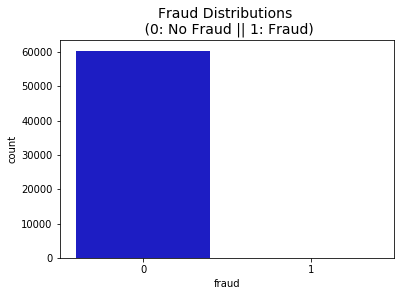

In [23]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('fraud', data=df, palette=colors)
plt.title('Fraud Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

##### Lets investigate if there is any distinct differences between fraud and non-fraud cases!

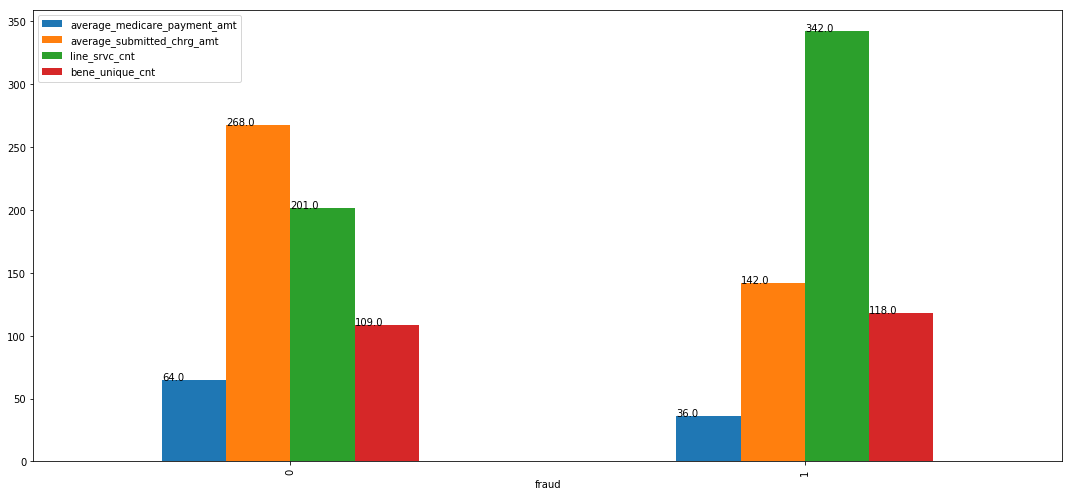

In [24]:
fig, ax = plt.subplots(figsize=(15,7))
fig.tight_layout()

#five categorical columns and three numerical columns of interest
for i, category in enumerate(["fraud"]):   
    ax = ax
    df.groupby("fraud").mean()[[
"average_medicare_payment_amt",
"average_submitted_chrg_amt","line_srvc_cnt","bene_unique_cnt"]].plot.bar(rot=0, ax=ax)

#Rotating xticks for all
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    fig.tight_layout()

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),0)), (p.get_x() * 1, p.get_height() * 1))


##### Interestingly, we see that average charges submitted is considerably lower for fraud cases than non fraud cases.  Now, lets see the average total submitted charges for all services per provider. 

In [25]:
df["total_medicare_payment_amt"] = df.line_srvc_cnt*df.average_medicare_payment_amt
df["total_submitted_chrg_amt"] = df.line_srvc_cnt*df.average_submitted_chrg_amt
#df["total_medicare_payment_amt(sq)"] = df.average_medicare_payment_amt*df.average_medicare_payment_amt
#df["total_submitted_chrg_amt(sq)"] = df.average_submitted_chrg_amt*df.average_submitted_chrg_amt

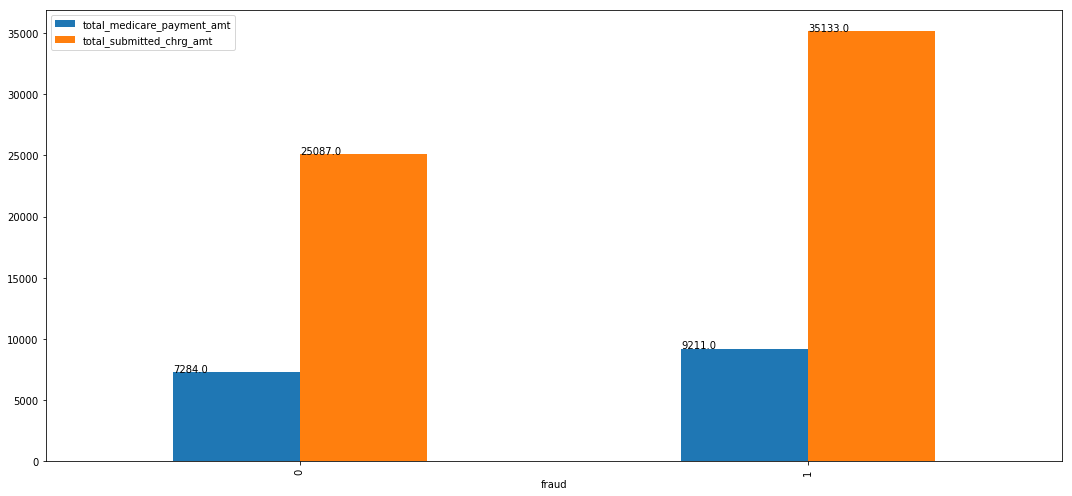

In [26]:
fig, ax = plt.subplots(figsize=(15,7))
fig.tight_layout()

#five categorical columns and three numerical columns of interest
for i, category in enumerate(["fraud"]):   
    ax = ax
    df.groupby("fraud").mean()[[
"total_medicare_payment_amt",
"total_submitted_chrg_amt"]].plot.bar(rot=0, ax=ax)

#Rotating xticks for all
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    fig.tight_layout()

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),0)), (p.get_x() * 1, p.get_height() * 1))


##### The average total charges submitted by fraud providers is approx 40% higher than non fraud providers! 

## How is the spread of the dataset?

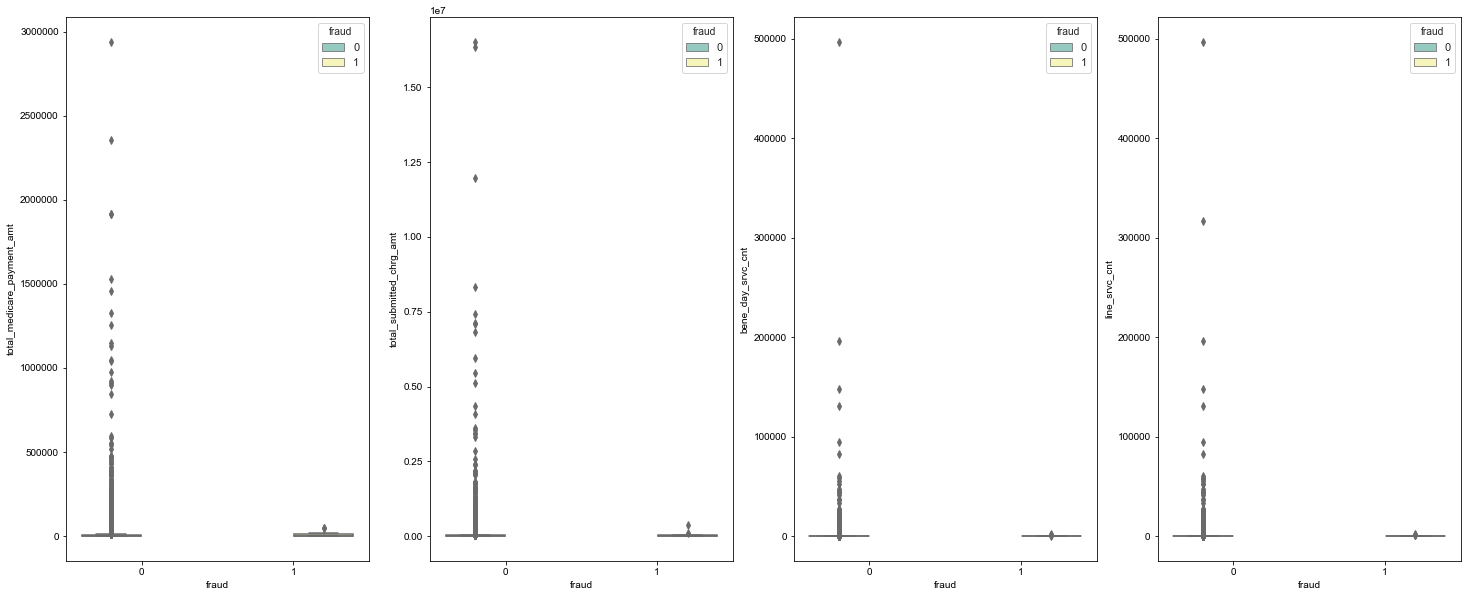

In [27]:
box_ = df[[
"total_medicare_payment_amt",
"total_submitted_chrg_amt",
"bene_day_srvc_cnt",
"bene_unique_cnt",
"line_srvc_cnt","fraud"]]

f, axes = plt.subplots(ncols=4, figsize=(25,10))
sns.set(style="whitegrid")
#ax = sns.boxplot(x="fraud", y="total_medicare_allowed_amt", hue="fraud", data=box_, palette="Set3", ax=axes[0])
ax = sns.boxplot(x="fraud", y="total_medicare_payment_amt", hue="fraud", data=box_, palette="Set3", ax=axes[0])
#ax = sns.boxplot(x="fraud", y="total_medicare_standard_amt", hue="fraud", data=box_, palette="Set3", ax=axes[2])
ax = sns.boxplot(x="fraud", y="total_submitted_chrg_amt", hue="fraud", data=box_, palette="Set3", ax=axes[1])
ax = sns.boxplot(x="fraud", y="bene_day_srvc_cnt", hue="fraud", data=box_, palette="Set3", ax=axes[2])
ax = sns.boxplot(x="fraud", y="line_srvc_cnt", hue="fraud", data=box_, palette="Set3", ax=axes[3])

#### Define X and Y

In [28]:
X = df.drop(['fraud','npi'], axis=1)
y = df['fraud']

In [29]:
X.shape

(60395, 7)

#### Standardize X 

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)

##### Next we are going to explore few approaches/techniques to handle the imbalanced dataset:
1. Train-Test Split, followed by undersampling/oversampling of the train dataset
2. Perform stratified k-folds and perform undersampling/oversamplng during k-folds (i.e. under/oversampling of each train dataset in each fold)

## Train-Test Split:

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42, stratify=y)

## Undersampling (non fraud cases) Train Dataset:
reference: https://knowledgengg.wordpress.com/2019/03/04/this-is-suresh/

There are a number of undersampling techniques to consider:
- RANDOM UNDERSAMPLING : As explained by its name, this technique will randomly remove the samples from the majority class of sample. Disadvantage with this method is there is always a good amount of probability of loosing the actual information and retaining the outliers in the samples in most of the cases. 
<br><b>Verdict</b>: We will not use this technique for obvious reason. :)
<br>

- NEARMISS – 1: Mainly based on K-Nearest Neighbors approach. In Nearmiss algorithm the technique used is to calculate the mean distances from majority class to the minority class and retain the points whose mean distance from majority class to minority class is lowest by ranking them in order. It will remove data points in majority class which are farthest from the minority class. This Nearmiss-1 will try to retain the data that is close to the decision boundary. It works well on more scattered data. K or size of neighbor hood will be our hyper parameter . 
<br><b>Verdict</b>: We will skip this as well since our dataset is not very scattered.
<br>

- NEARMISS – 2: will work similar to Nearmiss-1. Nearmiss 2 algorithm works by , instead of looking of K-Nearest points, it will look at the K-farthest points and rank them in the farthest first order. Based on the sampling ratio provided it will remove the first n points from the majority class. This is more helpful in removing outliers and re sampled data is more concentrated in the center. 
<br><b>Verdict</b>: We will use this approach.
<br>

- NEARMISS – 3 technique will pick K-nearest Neighbors to each points in the minority class and retain those majority class points which lie in those neighborhood . Here we cannot choose the ratio, even if we choose the ratio that won’t be of much help as neighborhood defines the ratio. If we use this technique the resultant data will have more overlapping between the classes and won’t be of much help if we are using logistic regression model. 
<br><b>Verdict</b>: Doesn't sound nice to have too much overlapping between the classes. NEXT!
<br>

- CNN(condensed nearest neighbor) try to reduce or remove the points in the majority class which are closer to the points in the majority class. CNN algorithm randomly selects a point in random and scans for all the nearest neighbor from that point and try to eliminate them. This process will be repeated until the sample ratio is reached or there is minimum balance between the class is reached. As this process is done by selecting a point in random points as a result whole process will go on random. Because of this reason this algorithm is a high variance one. Over all those this will take longest of all the re sampling algorithms. 
<br><b>Verdict</b>: This would be challenging as our dataset is quite big. We will not use this as we cannot specify the ratio. Most likley the resultant data will be still extremely unbalanced. 
<br>

- Edited nearest neighbour (ENN) ENN algorithm will remove the nearest neighbors whose class label is different from the majority K-nearest neighbors. The process is repeated until none of the points can be edited from the sample set. This is called Repeated ENN. This method is one of the most commonly used.
<br><b>Verdict</b>: We will not use this as we cannot specify the ratio. Most likley the resultant data will be still extremely unbalanced. 
<br>

- Tomek link is a pair of points in the sample, which are each other’s Nearest Neighbors but labeled as different class. This technique is basically used to remove the noisy and borderline example from the sample to get a better decision boundary. A variant of this will only remove the Tomek link of the majority class.
<br><b>Verdict</b>: We will not use this as we cannot specify the ratio. Most likley the resultant data will be still extremely unbalanced. 

In [32]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours, TomekLinks
# Edited Nearest Neighbor (ENN)

us = NearMiss(ratio=0.002, n_neighbors=3, version=2, random_state=42)
X_train_NM2, y_train_NM2 = us.fit_sample(X_train, y_train)
print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_NM2)))

Distribution of class labels before resampling Counter({0: 42262, 1: 14})
Distribution of class labels after resampling Counter({0: 7000, 1: 14})


## Oversampling (fraud cases) Train Dataset:
reference: https://knowledgengg.wordpress.com/2019/03/04/this-is-suresh/

There are a number of oversampling techniques to consider:
- RANDOM OVERSAMPLING : Random Over sampling will randomly generate the samples by adding little bit of jitters to the existing samples in the minority class. This may cause overlapping of the data points and not much helpful always. This may lead to overfitting. 
<br><b>Verdict</b>: We will not use this technique for obvious reason. :)
<br>

- SYMMETRIC MINORITY OVERSAMPLING TECHNIQUE :(SMOTE): SMOTE will randomly select a sample from the minority class then finds a nearest Neighbor to it and draws a imaginary line between the sample points , crates new sample point on that line. This process is repeated until the desired ratio of the classes is reached.
<br><b>Verdict</b>: Good to consider.
<br>

- SMOTE + TOMEK LINK REMOVAL : This Technique will combine the SMOTE and TOMEK together. This technique will under sample the majority class as well as over sample the minority class using both of the techniques together.
<br><b>Verdict</b>: This will be much useful with the data sets with huge data imbalance and also deals with the untidy data and noisy data. We will use this!
<br>

In [33]:
os_us = SMOTETomek(ratio=0.2,random_state=42)
X_train_SMTO, y_train_SMTO = os_us.fit_sample(X_train, y_train)
print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_SMTO)))

Distribution of class labels before resampling Counter({0: 42262, 1: 14})
Distribution of class labels after resampling Counter({0: 42259, 1: 8449})


### Splitting the Data using StratifiedKFold & perform undersampling/oversampling for each training data!

In [34]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [35]:
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)

for train_index, test_index in kfold.split(X,y):
    print("Train:", train_index, "Test:", test_index)
    X_train_KF, X_test_KF = X.iloc[train_index], X.iloc[test_index]
    y_train_KF, y_test_KF = y.iloc[train_index], y.iloc[test_index]
    os_us = SMOTETomek(ratio=0.2,random_state=42)
    X_train_KF_SMTO, y_train_KF_SMTO = os_us.fit_sample(X_train_KF, y_train_KF)

Train: [12076 12077 12078 ... 60392 60393 60394] Test: [    0     1     2 ... 12245 14798 17791]
Train: [    0     1     2 ... 60392 60393 60394] Test: [12076 12077 12078 ... 24155 24156 24157]
Train: [    0     1     2 ... 60392 60393 60394] Test: [24158 24159 24160 ... 36419 36554 42218]
Train: [    0     1     2 ... 60392 60393 60394] Test: [36234 36235 36236 ... 60388 60389 60390]
Train: [    0     1     2 ... 60388 60389 60390] Test: [48312 48313 48314 ... 60392 60393 60394]


In [36]:
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)

for train_index, test_index in kfold.split(X,y):
    print("Train:", train_index, "Test:", test_index)
    X_train_KF2, X_test_KF2 = X.iloc[train_index], X.iloc[test_index]
    y_train_KF2, y_test_KF2 = y.iloc[train_index], y.iloc[test_index]
    us = NearMiss(ratio=0.002, n_neighbors=3, version=2, random_state=42)
    X_train_KF_NM2, y_train_KF_NM2 = us.fit_sample(X_train_KF2, y_train_KF2)

Train: [12076 12077 12078 ... 60392 60393 60394] Test: [    0     1     2 ... 12245 14798 17791]
Train: [    0     1     2 ... 60392 60393 60394] Test: [12076 12077 12078 ... 24155 24156 24157]
Train: [    0     1     2 ... 60392 60393 60394] Test: [24158 24159 24160 ... 36419 36554 42218]
Train: [    0     1     2 ... 60392 60393 60394] Test: [36234 36235 36236 ... 60388 60389 60390]
Train: [    0     1     2 ... 60388 60389 60390] Test: [48312 48313 48314 ... 60392 60393 60394]


## Model Evaluation Metrics

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score

#results = pd.DataFrame(columns = ['Model', "Best_Param", 'Accuracy', 'Precision', 'Recall', "True Neg", "False Pos", "False Neg", "True Pos", 'F1 Score', "ROC AUC"])
results =[]

class MODEL_EVA:
   
    def __init__(self, model, best_param, y_test_, y_pred, y_pred_prob):
        self.model = model
        self.best_param = best_param
        self.y_test_ = y_test_
        self.y_pred = y_pred
        self.y_pred_prob = y_pred_prob
        
    def confusion_matrix (self):
        self.accuracy  = accuracy_score(self.y_test_, self.y_pred)
        self.precision = precision_score(self.y_test_, self.y_pred)
        self.recall    = recall_score(self.y_test_, self.y_pred)
        self.f1        = 2 * (self.precision * self.recall) / (self.precision + self.recall)
        #dt_fpr, dt_tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
        #self.roc_auc = auc(dt_fpr, dt_tpr)
        self.roc_auc = roc_auc_score(np.array(self.y_test_),np.array(self.y_pred_prob))

        print("Model: {}"  .format(self.model))
        print("Best Param: {}"  .format(self.best_param))
        print("------------------------------------")
        print("Accuracy:\t%.4f" % (self.accuracy))
        print("Precision:\t%.4f" % (self.precision))
        print("Recall:\t\t%.4f" % (self.recall))
        print("F1 Score:\t%.4f" % (2 * (self.precision * self.recall) / (self.precision + self.recall)))
        print("roc_auc:\t%.4f" % (self.roc_auc))
        
        tn, fp, fn, tp = confusion_matrix(self.y_test_, self.y_pred).ravel()
        print("True Negatives: %s" % tn)
        print("False Positives: %s" % fp)
        print("False Negatives: %s" % fn)
        print("True Positives: %s" % tp)
        self.tn = tn
        self.fp = fp
        self.fn = fn
        self.tp = tp
        
    def store_result (self):
        result_dict = {
            'Model': self.model,
            "Best_Param": self.best_param,
            'Accuracy': self.accuracy,
            'Precision': self.precision,
            'Recall': self.recall,
            "True Negatives": self.tn,
            "False Positives": self.fp,
            "False Negatives": self.fn,
            "True Positives": self.tp,
            'F1 Score': self.f1,
            "ROC AUC" : self.roc_auc}
        results.append ([self.model, self.best_param, self.accuracy, self.precision, self.recall, self.tn, self.fp, self.fn, self.tp, self.f1, self.roc_auc])
        results_df = pd.DataFrame(results,columns = ['Model', "Best_Param", 'Accuracy', 'Precision', 'Recall', "True Neg", "False Pos", "False Neg", "True Pos", 'F1 Score', "ROC AUC"])
        return results_df

### Classifiers 

-As the dataset is extremely imbalanced, we evaluate our models using f1 and confusion matrix instead of roc_auc_score.<br>
-Logistic Regression appears to perform better with oversampling dataset while adaboost and random forest performs better with undersampling dataset.  
-Our best model = logistic regression with oversampling dataset (without stratified kfolds).  The model is able to detect 5 out of 6 fraud csaes, with relatively lower no. of false positive signals.

In [ ]:
#Use GridSearchCV to find the best parameters using undersample dataset. 

from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, scoring="f1_micro")
grid_log_reg.fit(X_train_NM2, y_train_NM2)
# We automatically get the logistic regression with the best parameters.
log_reg_NM2 = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params, scoring="f1_micro")
grid_knears.fit(X_train_NM2, y_train_NM2)

# KNears best estimator
knears_neighbors_NM2 = grid_knears.best_estimator_

# Adaboost Classifier
ada_params = {
 'n_estimators': [5,10,15,50],
 'base_estimator__max_depth' : [1,5,10],
 'algorithm' : ['SAMME',"SAMME.R"]
 }

grid_ada = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), ada_params, scoring="f1_micro")
grid_ada.fit(X_train_NM2, y_train_NM2)

# ada best estimator
ada_clf_NM2 = grid_ada.best_estimator_

# random forest Classifier
rf_params = {
 'n_estimators': [20, 50, 100],
 'min_samples_split': [2,3,4,5,6,7,8,9,10],
 'min_samples_leaf': [1,4,5],
 'max_features': ['auto'],
 'max_depth': [1,2,3,4,5,6,7,8,9,10],
 'bootstrap': [True]}

grid_rf = GridSearchCV(RandomForestClassifier(), rf_params, scoring="f1_micro")
grid_rf.fit(X_train_NM2, y_train_NM2)

# ada best estimator
rf_clf_NM2 = grid_rf.best_estimator_

In [ ]:
# Use GridSearchCV to find the best parameters using oversample dataset. 

from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, scoring="f1_micro")
grid_log_reg.fit(X_train_SMTO, y_train_SMTO)
# We automatically get the logistic regression with the best parameters.
log_reg_SMTO = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params, scoring="f1_micro")
grid_knears.fit(X_train_SMTO, y_train_SMTO)

# KNears best estimator
knears_neighbors_SMTO = grid_knears.best_estimator_

# Adaboost Classifier
ada_params = {
 'n_estimators': [5,10,15,50],
 'base_estimator__max_depth' : [1,5,10],
 'algorithm' : ['SAMME',"SAMME.R"]
 }

grid_ada = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), ada_params, scoring="f1_micro")
grid_ada.fit(X_train_SMTO, y_train_SMTO)

# ada best estimator
ada_clf_SMTO = grid_ada.best_estimator_

# random forest Classifier
rf_params = {
 'n_estimators': [20, 50, 100],
 'min_samples_split': [2,3,4,5,6,7,8,9,10],
 'min_samples_leaf': [1,4,5],
 'max_features': ['auto'],
 'max_depth': [1,2,3,4,5,6,7,8,9,10],
 'bootstrap': [True]}

grid_rf = GridSearchCV(RandomForestClassifier(), rf_params, scoring="f1_micro")
grid_rf.fit(X_train_SMTO, y_train_SMTO)

# ada best estimator
rf_clf_SMTO = grid_rf.best_estimator_

In [ ]:
# Use GridSearchCV to find the best parameters dataset that undergoes KFold, then undersampling

from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, scoring="f1_micro")
grid_log_reg.fit(X_train_KF_NM2,y_train_KF_NM2)
# We automatically get the logistic regression with the best parameters.
log_reg_kf_NM2 = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params, scoring="f1_micro")
grid_knears.fit(X_train_KF_NM2,y_train_KF_NM2)

# KNears best estimator
knears_neighbors_kf_NM2 = grid_knears.best_estimator_

# Adaboost Classifier
ada_params = {
 'n_estimators': [5,10,15,50],
 'base_estimator__max_depth' : [1,5,10],
 'algorithm' : ['SAMME',"SAMME.R"]
 }

grid_ada = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), ada_params, scoring="f1_micro")
grid_ada.fit(X_train_KF_NM2,y_train_KF_NM2)

# ada best estimator
ada_clf_kf_NM2 = grid_ada.best_estimator_


# random forest Classifier
rf_params = {
 'n_estimators': [20, 50, 100],
 'min_samples_split': [2,3,4,5,6,7,8,9,10],
 'min_samples_leaf': [1,4,5],
 'max_features': ['auto'],
 'max_depth': [1,2,3,4,5,6,7,8,9,10],
 'bootstrap': [True]}

grid_rf = GridSearchCV(RandomForestClassifier(), rf_params, scoring="f1_micro")
grid_rf.fit(X_train_KF_NM2,y_train_KF_NM2)

# rf best estimator
rf_clf_kf_NM2 = grid_rf.best_estimator_

In [ ]:
# Use GridSearchCV to find the best parameters dataset that undergoes KFold, then oversampling

from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, scoring="f1_micro")
grid_log_reg.fit(X_train_KF_SMTO,y_train_KF_SMTO)
# We automatically get the logistic regression with the best parameters.
log_reg_kf_SMTO = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params, scoring="f1_micro")
grid_knears.fit(X_train_KF_SMTO,y_train_KF_SMTO)

# KNears best estimator
knears_neighbors_kf_SMTO = grid_knears.best_estimator_

# Adaboost Classifier
ada_params = {
 'n_estimators': [5,10,15,50],
 'base_estimator__max_depth' : [1,5,10],
 'algorithm' : ['SAMME',"SAMME.R"]
 }

grid_ada = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), ada_params, scoring="f1_micro")
grid_ada.fit(X_train_KF_SMTO,y_train_KF_SMTO)

# ada best estimator
ada_clf_kf_SMTO = grid_ada.best_estimator_

# random forest Classifier
rf_params = {
 'n_estimators': [20, 50, 100],
 'min_samples_split': [2,3,4,5,6,7,8,9,10],
 'min_samples_leaf': [1,4,5],
 'max_features': ['auto'],
 'max_depth': [1,2,3,4,5,6,7,8,9,10],
 'bootstrap': [True]}

grid_rf = GridSearchCV(RandomForestClassifier(), rf_params, scoring="f1_micro")
grid_rf.fit(X_train_KF_SMTO,y_train_KF_SMTO)

# rf best estimator
rf_clf_kf_SMTO = grid_rf.best_estimator_

In [ ]:
print ("log_reg_NM2={}".format(log_reg_NM2))

print ("ada_clf_NM2={}".format(ada_clf_NM2))

print ("rf_clf_NM2={}".format(rf_clf_NM2))
       
##----
print ("log_reg_SMTO={}".format(log_reg_SMTO))

print ("ada_clf_SMTO={}".format(ada_clf_SMTO))
    
print ("rf_clf_SMTO={}".format(rf_clf_SMTO))
       
       
##----
print ("log_reg_kf_NM2={}".format(log_reg_kf_NM2)) 
    
print ("ada_clf_kf_NM2={}".format(ada_clf_kf_NM2)) 
       
print ("rf_clf_kf_NM2={}".format(rf_clf_kf_NM2)) 
       
##----
print ("log_reg_kf_SMTO={}".format(log_reg_kf_SMTO))

print ("ada_clf_kf_SMTO={}".format(ada_clf_kf_SMTO))
    
print ("rf_clf_kf_SMTO={}".format(rf_clf_kf_SMTO))

#### Best Param - F1 Micro

In [43]:
class_weight={1:0.85,0:0.15}

In [44]:
log_reg_NM2=LogisticRegression(C=0.001, class_weight=class_weight, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
ada_clf_NM2=AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=class_weight, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)
rf_clf_NM2=RandomForestClassifier(bootstrap=True, class_weight=class_weight, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
log_reg_SMTO=LogisticRegression(C=100, class_weight=class_weight, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
ada_clf_SMTO=AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)
rf_clf_SMTO=RandomForestClassifier(bootstrap=True, class_weight=class_weight, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
log_reg_kf_NM2=LogisticRegression(C=0.001, class_weight=class_weight, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
ada_clf_kf_NM2=AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=class_weight, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=10, random_state=None)
rf_clf_kf_NM2=RandomForestClassifier(bootstrap=True, class_weight=class_weight, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
log_reg_kf_SMTO=LogisticRegression(C=1000, class_weight=class_weight, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
ada_clf_kf_SMTO=AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=class_weight, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)
rf_clf_kf_SMTO=RandomForestClassifier(bootstrap=True, class_weight=class_weight, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Logistic Regression 

In [45]:
#with oversampled dataset
lg_SMTO = log_reg_SMTO.fit(X_train_SMTO,y_train_SMTO)
lg_SMTO_pred_prob = lg_SMTO.predict_proba(X_test)[:,1]
lg_SMTO_pred = lg_SMTO.predict(X_test)
lg_SMTO_test_ = y_test
lrg_SMTO = MODEL_EVA ("lg_SMTO",log_reg_SMTO,lg_SMTO_test_, lg_SMTO_pred,lg_SMTO_pred_prob)
lrg_SMTO.confusion_matrix()
lrg_SMTO.store_result()

#with Kfolded oversampled dataset
lg_SMTO_kf = log_reg_kf_SMTO.fit(X_train_KF_SMTO,y_train_KF_SMTO)
lg_SMTO_kf_pred_prob = lg_SMTO_kf.predict_proba(X_test_KF)[:,1]
lg_SMTO_kf_pred = lg_SMTO_kf.predict(X_test_KF)
lg_SMTO_kf_test_ = y_test_KF
lrg_SMTO_kf = MODEL_EVA ("lg_SMTO_kf",log_reg_kf_SMTO,lg_SMTO_kf_test_, lg_SMTO_kf_pred,lg_SMTO_kf_pred_prob)
lrg_SMTO_kf.confusion_matrix()
lrg_SMTO_kf.store_result()

#with undersampled dataset
lg_NM2 = log_reg_NM2.fit(X_train_NM2,y_train_NM2)
lg_NM2_pred_prob = lg_NM2.predict_proba(X_test)[:,1]
lg_NM2_pred = lg_NM2.predict(X_test)
lg_NM2_test_ = y_test
lrg_NM2 = MODEL_EVA ("lg_NM2",log_reg_NM2,lg_NM2_test_, lg_NM2_pred,lg_NM2_pred_prob)
lrg_NM2.confusion_matrix()
lrg_NM2.store_result()

#with Kfolded undersampled dataset
lg_NM2_kf = log_reg_kf_NM2.fit(X_train_KF_NM2,y_train_KF_NM2)
lg_NM2_kf_pred_prob = lg_NM2_kf.predict_proba(X_test_KF2)[:,1]
lg_NM2_kf_pred = lg_NM2_kf.predict(X_test_KF2)
lg_NM2_kf_test_ = y_test_KF2
lrg_NM2_kf = MODEL_EVA ("lg_NM2_kf",log_reg_kf_NM2,lg_NM2_kf_test_ , lg_NM2_kf_pred,lg_NM2_kf_pred_prob)
lrg_NM2_kf.confusion_matrix()
lrg_NM2_kf.store_result()

Model: lg_SMTO
Best Param: LogisticRegression(C=100, class_weight={1: 0.85, 0: 0.15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
------------------------------------
Accuracy:	0.6376
Precision:	0.0008
Recall:		0.8333
F1 Score:	0.0015
roc_auc:	0.7340
True Negatives: 11548
False Positives: 6565
False Negatives: 1
True Positives: 5
Model: lg_SMTO_kf
Best Param: LogisticRegression(C=1000, class_weight={1: 0.85, 0: 0.15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
------------------------------------
Accuracy:	0.5757
Precision:	0.0006
Recall:		0.7500
F1 Score:	0.0012
roc_auc:	0.6220
True Negatives: 6951
False Positives: 5124
False Negatives: 1
T

,Model,Best_Param,Accuracy,Precision,Recall,True Neg,False Pos,False Neg,True Pos,F1 Score,ROC AUC
0,lg_SMTO,"LogisticRegression(C=100, class_weight={1: 0.8...",0.637618,0.000761,0.833333,11548,6565,1,5,0.001521,0.733985
1,lg_SMTO_kf,"LogisticRegression(C=1000, class_weight={1: 0....",0.575710,0.000585,0.750000,6951,5124,1,3,0.001169,0.622050
2,lg_NM2,"LogisticRegression(C=0.001, class_weight={1: 0...",0.999669,0.000000,0.000000,18113,0,6,0,NaN,0.500000
3,lg_NM2_kf,"LogisticRegression(C=0.001, class_weight={1: 0...",0.999669,0.000000,0.000000,12075,0,4,0,NaN,0.500000


### Adaboost

In [46]:
#with oversampled dataset
ada_SMTO = ada_clf_SMTO.fit(X_train_SMTO,y_train_SMTO)
ada_SMTO_pred_prob =ada_SMTO.predict_proba(X_test)[:,1]
ada_SMTO_pred = ada_SMTO.predict(X_test)
ada_SMTO_test_ = y_test
adag_SMTO = MODEL_EVA ("ada_SMTO",ada_clf_SMTO,ada_SMTO_test_, ada_SMTO_pred,ada_SMTO_pred_prob)
adag_SMTO.confusion_matrix()
adag_SMTO.store_result()

#with Kfolded oversampled dataset
ada_SMTO_kf = ada_clf_kf_SMTO.fit(X_train_KF_SMTO,y_train_KF_SMTO)
ada_SMTO_kf_pred_prob = ada_SMTO_kf.predict_proba(X_test_KF)[:,1]
ada_SMTO_kf_pred = ada_SMTO_kf.predict(X_test_KF)
ada_SMTO_kf_test_ = y_test_KF
adag_SMTO_kf = MODEL_EVA ("ada_SMTO_kf",ada_clf_kf_SMTO,ada_SMTO_kf_test_, ada_SMTO_kf_pred,ada_SMTO_kf_pred_prob)
adag_SMTO_kf.confusion_matrix()
adag_SMTO_kf.store_result()

#with undersampled dataset
ada_NM2 = ada_clf_NM2.fit(X_train_NM2,y_train_NM2)
ada_NM2_pred_prob = ada_NM2.predict_proba(X_test)[:,1]
ada_NM2_pred = ada_NM2.predict(X_test)
ada_NM2_test_ = y_test
adag_NM2 = MODEL_EVA ("ada_NM2",ada_clf_NM2,ada_NM2_test_, ada_NM2_pred,ada_NM2_pred_prob)
adag_NM2.confusion_matrix()
adag_NM2.store_result()

#with Kfolded undersampled dataset
ada_NM2_kf = ada_clf_kf_NM2.fit(X_train_KF_NM2,y_train_KF_NM2)
ada_NM2_kf_pred_prob = ada_NM2_kf.predict_proba(X_test_KF2)[:,1]
ada_NM2_kf_pred = ada_NM2_kf.predict(X_test_KF2)
ada_NM2_kf_test_ = y_test_KF2
adag_NM2_kf = MODEL_EVA ("ada_NM2_kf",ada_clf_kf_NM2,ada_NM2_kf_test_, ada_NM2_kf_pred,ada_NM2_kf_pred_prob)
adag_NM2_kf.confusion_matrix()
adag_NM2_kf.store_result()

Model: ada_SMTO
Best Param: AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)
------------------------------------
Accuracy:	0.9980
Precision:	0.0000
Recall:		0.0000
F1 Score:	nan
roc_auc:	0.5219
True Negatives: 18083
False Positives: 30
False Negatives: 6
True Positives: 0
Model: ada_SMTO_kf
Best Param: AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight={1: 0.85, 0: 0.15}, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,


,Model,Best_Param,Accuracy,Precision,Recall,True Neg,False Pos,False Neg,True Pos,F1 Score,ROC AUC
0,lg_SMTO,"LogisticRegression(C=100, class_weight={1: 0.8...",0.637618,0.000761,0.833333,11548,6565,1,5,0.001521,0.733985
1,lg_SMTO_kf,"LogisticRegression(C=1000, class_weight={1: 0....",0.575710,0.000585,0.750000,6951,5124,1,3,0.001169,0.622050
2,lg_NM2,"LogisticRegression(C=0.001, class_weight={1: 0...",0.999669,0.000000,0.000000,18113,0,6,0,NaN,0.500000
3,lg_NM2_kf,"LogisticRegression(C=0.001, class_weight={1: 0...",0.999669,0.000000,0.000000,12075,0,4,0,NaN,0.500000
4,ada_SMTO,"(DecisionTreeClassifier(class_weight=None, cri...",0.998013,0.000000,0.000000,18083,30,6,0,NaN,0.521886
5,ada_SMTO_kf,"(DecisionTreeClassifier(class_weight={1: 0.85,...",0.998427,0.000000,0.000000,12060,15,4,0,NaN,0.870352
6,ada_NM2,"(DecisionTreeClassifier(class_weight={1: 0.85,...",0.426790,0.000385,0.666667,7729,10384,2,4,0.000770,0.589466
7,ada_NM2_kf,"(DecisionTreeClassifier(class_weight={1: 0.85,...",0.432321,0.000292,0.500000,5220,6855,2,2,0.000583,0.512112


### Random Forest

In [47]:
#with oversampled dataset
rf_SMTO = rf_clf_SMTO.fit(X_train_SMTO,y_train_SMTO)
rf_SMTO_pred_prob =rf_SMTO.predict_proba(X_test)[:,1]
rf_SMTO_pred = rf_SMTO.predict(X_test)
rf_SMTO_test_ = y_test
rfg_SMTO = MODEL_EVA ("rf_SMTO",rf_clf_SMTO,rf_SMTO_test_, rf_SMTO_pred,rf_SMTO_pred_prob)
rfg_SMTO.confusion_matrix()
rfg_SMTO.store_result()

#with Kfolded oversampled dataset
rf_SMTO_kf = rf_clf_kf_SMTO.fit(X_train_KF_SMTO,y_train_KF_SMTO)
rf_SMTO_kf_pred_prob = rf_SMTO_kf.predict_proba(X_test_KF)[:,1]
rf_SMTO_kf_pred = rf_SMTO_kf.predict(X_test_KF)
rf_SMTO_kf_test_ = y_test_KF
rfg_SMTO_kf = MODEL_EVA ("rf_SMTO_kf",rf_clf_kf_SMTO,rf_SMTO_kf_test_, rf_SMTO_kf_pred,rf_SMTO_kf_pred_prob)
rfg_SMTO_kf.confusion_matrix()
rfg_SMTO_kf.store_result()

#with undersampled dataset
rf_NM2 = rf_clf_NM2.fit(X_train_NM2,y_train_NM2)
rf_NM2_pred_prob = rf_NM2.predict_proba(X_test)[:,1]
rf_NM2_pred = rf_NM2.predict(X_test)
rf_NM2_test_ = y_test
rfg_NM2 = MODEL_EVA ("rf_NM2",rf_clf_NM2,rf_NM2_test_, rf_NM2_pred,rf_NM2_pred_prob)
rfg_NM2.confusion_matrix()
rfg_NM2.store_result()

#with Kfolded undersampled dataset
rf_NM2_kf = rf_clf_kf_NM2.fit(X_train_KF_NM2,y_train_KF_NM2)
rf_NM2_kf_pred_prob = rf_NM2_kf.predict_proba(X_test_KF2)[:,1]
rf_NM2_kf_pred = rf_NM2_kf.predict(X_test_KF2)
rf_NM2_kf_test_ = y_test_KF2
rfg_NM2_kf = MODEL_EVA ("rf_NM2_kf",rf_clf_kf_NM2,rf_NM2_kf_test_, rf_NM2_kf_pred,rf_NM2_kf_pred_prob)
rfg_NM2_kf.confusion_matrix()
rfg_NM2_kf.store_result()

Model: rf_SMTO
Best Param: RandomForestClassifier(bootstrap=True, class_weight={1: 0.85, 0: 0.15},
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
------------------------------------
Accuracy:	0.8608
Precision:	0.0008
Recall:		0.3333
F1 Score:	0.0016
roc_auc:	0.4680
True Negatives: 15595
False Positives: 2518
False Negatives: 4
True Positives: 2
Model: rf_SMTO_kf
Best Param: RandomForestClassifier(bootstrap=True, class_weight={1: 0.85, 0: 0.15},
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=4, min_weight_fractio

,Model,Best_Param,Accuracy,Precision,Recall,True Neg,False Pos,False Neg,True Pos,F1 Score,ROC AUC
0,lg_SMTO,"LogisticRegression(C=100, class_weight={1: 0.8...",0.637618,0.000761,0.833333,11548,6565,1,5,0.001521,0.733985
1,lg_SMTO_kf,"LogisticRegression(C=1000, class_weight={1: 0....",0.575710,0.000585,0.750000,6951,5124,1,3,0.001169,0.622050
2,lg_NM2,"LogisticRegression(C=0.001, class_weight={1: 0...",0.999669,0.000000,0.000000,18113,0,6,0,NaN,0.500000
3,lg_NM2_kf,"LogisticRegression(C=0.001, class_weight={1: 0...",0.999669,0.000000,0.000000,12075,0,4,0,NaN,0.500000
4,ada_SMTO,"(DecisionTreeClassifier(class_weight=None, cri...",0.998013,0.000000,0.000000,18083,30,6,0,NaN,0.521886
5,ada_SMTO_kf,"(DecisionTreeClassifier(class_weight={1: 0.85,...",0.998427,0.000000,0.000000,12060,15,4,0,NaN,0.870352
6,ada_NM2,"(DecisionTreeClassifier(class_weight={1: 0.85,...",0.426790,0.000385,0.666667,7729,10384,2,4,0.000770,0.589466
7,ada_NM2_kf,"(DecisionTreeClassifier(class_weight={1: 0.85,...",0.432321,0.000292,0.500000,5220,6855,2,2,0.000583,0.512112
8,rf_SMTO,"(DecisionTreeClassifier(class_weight=None, cri...",0.860809,0.000794,0.333333,15595,2518,4,2,0.001584,0.468025
9,rf_SMTO_kf,"(DecisionTreeClassifier(class_weight=None, cri...",0.936667,0.000000,0.000000,11314,761,4,0,NaN,0.691718


### Finding the best weights for ensemble models

In [48]:
from sklearn.ensemble import VotingClassifier

import pandas as pd

np.random.seed(123)

vc_weights_NM2KF = pd.DataFrame(columns=('w1', 'w2', 'w3', 'FP', 'TP'))

i = 0
for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range(1,4):

            if len(set((w1,w2,w3))) == 1: # skip if all weights are equal
                continue

            eclf = VotingClassifier(estimators=[ ("lg_NM2_kf", lg_NM2_kf),("rf_NM2_kf", rf_NM2_kf), ("ada_NM2_kf", ada_NM2_kf)], weights=[w1,w2,w3], voting="soft")
            eclf= eclf.fit(X_train_KF_NM2,y_train_KF_NM2)
            eclf_pred_prob = eclf.predict_proba(X_test_KF2)[:,1]
            eclf_pred = eclf.predict(X_test_KF2)
            eclf_test = y_test_KF2
            VC_eva = MODEL_EVA ("VC_NM2_kf_{}{}{}".format(w1,w2,w3),eclf,eclf_test, eclf_pred,eclf_pred_prob)
            VC_eva.confusion_matrix()
            VC_eva.store_result()

Model: VC_NM2_kf_112
Best Param: VotingClassifier(estimators=[('lg_NM2_kf', LogisticRegression(C=0.001, class_weight={1: 0.85, 0: 0.15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=F...ne,
            splitter='best'),
          learning_rate=1.0, n_estimators=10, random_state=None))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[1, 1, 2])
------------------------------------
Accuracy:	0.4323
Precision:	0.0003
Recall:		0.5000
F1 Score:	0.0006
roc_auc:	0.5555
True Negatives: 5220
False Positives: 6855
False Negatives: 2
True Positives: 2
Model: VC_NM2_kf_113
Best Param: VotingClassifier(estimators=[('lg_NM2_kf', LogisticRegression(C=0.001, class_weight={1: 0.85, 0: 0.15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None

Model: VC_NM2_kf_221
Best Param: VotingClassifier(estimators=[('lg_NM2_kf', LogisticRegression(C=0.001, class_weight={1: 0.85, 0: 0.15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=F...ne,
            splitter='best'),
          learning_rate=1.0, n_estimators=10, random_state=None))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[2, 2, 1])
------------------------------------
Accuracy:	0.5036
Precision:	0.0003
Recall:		0.5000
F1 Score:	0.0007
roc_auc:	0.5452
True Negatives: 6081
False Positives: 5994
False Negatives: 2
True Positives: 2
Model: VC_NM2_kf_223
Best Param: VotingClassifier(estimators=[('lg_NM2_kf', LogisticRegression(C=0.001, class_weight={1: 0.85, 0: 0.15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None

roc_auc:	0.5564
True Negatives: 7132
False Positives: 4943
False Negatives: 2
True Positives: 2
Model: VC_NM2_kf_332
Best Param: VotingClassifier(estimators=[('lg_NM2_kf', LogisticRegression(C=0.001, class_weight={1: 0.85, 0: 0.15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=F...ne,
            splitter='best'),
          learning_rate=1.0, n_estimators=10, random_state=None))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[3, 3, 2])
------------------------------------
Accuracy:	0.4987
Precision:	0.0003
Recall:		0.5000
F1 Score:	0.0007
roc_auc:	0.5636
True Negatives: 6022
False Positives: 6053
False Negatives: 2
True Positives: 2


In [49]:
from sklearn.ensemble import VotingClassifier

import pandas as pd

np.random.seed(123)

vc_weights_NM2 = pd.DataFrame(columns=('w1', 'w2', 'w3', 'FP', 'TP'))

i = 0
for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range(1,4):

            if len(set((w1,w2,w3))) == 1: # skip if all weights are equal
                continue

            eclf_ = VotingClassifier(estimators=[ ("lg_NM2", lg_NM2),("rf_NM2", rf_NM2), ("ada_NM2", ada_NM2)], weights=[w1,w2,w3], voting="soft")
            eclf_ = eclf_.fit(X_train_NM2,y_train_NM2)
            eclf_pred_prob = eclf_.predict_proba(X_test)[:,1]
            eclf_pred = eclf_.predict(X_test)
            eclf_test_ = y_test
            VC_eva = MODEL_EVA ("VC_NM2_{}{}{}".format(w1,w2,w3),eclf_,eclf_test_ , eclf_pred,eclf_pred_prob)
            VC_eva.confusion_matrix()
            VC_eva.store_result()

Model: VC_NM2_112
Best Param: VotingClassifier(estimators=[('lg_NM2', LogisticRegression(C=0.001, class_weight={1: 0.85, 0: 0.15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=Fals...ne,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[1, 1, 2])
------------------------------------
Accuracy:	0.4289
Precision:	0.0004
Recall:		0.6667
F1 Score:	0.0008
roc_auc:	0.6535
True Negatives: 7768
False Positives: 10345
False Negatives: 2
True Positives: 4
Model: VC_NM2_113
Best Param: VotingClassifier(estimators=[('lg_NM2', LogisticRegression(C=0.001, class_weight={1: 0.85, 0: 0.15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalt

Model: VC_NM2_223
Best Param: VotingClassifier(estimators=[('lg_NM2', LogisticRegression(C=0.001, class_weight={1: 0.85, 0: 0.15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=Fals...ne,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[2, 2, 3])
------------------------------------
Accuracy:	0.4268
Precision:	0.0004
Recall:		0.6667
F1 Score:	0.0008
roc_auc:	0.5644
True Negatives: 7729
False Positives: 10384
False Negatives: 2
True Positives: 4
Model: VC_NM2_231
Best Param: VotingClassifier(estimators=[('lg_NM2', LogisticRegression(C=0.001, class_weight={1: 0.85, 0: 0.15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalt

In [50]:
from sklearn.ensemble import VotingClassifier

import pandas as pd

np.random.seed(123)

vc_weights_SMTO = pd.DataFrame(columns=('w1', 'w2', 'w3', 'FP', 'TP'))

i = 0
for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range(1,4):

            if len(set((w1,w2,w3))) == 1: # skip if all weights are equal
                continue

            eclf_ = VotingClassifier(estimators=[ ("lg_SMTO", lg_SMTO),("rf_SMTO", rf_SMTO), ("ada_SMTO", ada_SMTO)], weights=[w1,w2,w3], voting="soft")
            eclf_ = eclf_.fit(X_train_SMTO,y_train_SMTO)
            eclf_pred_prob = eclf_.predict_proba(X_test)[:,1]
            eclf_pred = eclf_.predict(X_test)
            eclf_test_ = y_test
            VC_eva = MODEL_EVA ("VC_SMTO_{}{}{}".format(w1,w2,w3),eclf_,eclf_test_ , eclf_pred,eclf_pred_prob)
            VC_eva.confusion_matrix()
            VC_eva.store_result()


Model: VC_SMTO_112
Best Param: VotingClassifier(estimators=[('lg_SMTO', LogisticRegression(C=100, class_weight={1: 0.85, 0: 0.15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False...ne,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[1, 1, 2])
------------------------------------
Accuracy:	0.9555
Precision:	0.0012
Recall:		0.1667
F1 Score:	0.0025
roc_auc:	0.6789
True Negatives: 17312
False Positives: 801
False Negatives: 5
True Positives: 1
Model: VC_SMTO_113
Best Param: VotingClassifier(estimators=[('lg_SMTO', LogisticRegression(C=100, class_weight={1: 0.85, 0: 0.15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalt

Model: VC_SMTO_223
Best Param: VotingClassifier(estimators=[('lg_SMTO', LogisticRegression(C=100, class_weight={1: 0.85, 0: 0.15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False...ne,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[2, 2, 3])
------------------------------------
Accuracy:	0.9374
Precision:	0.0000
Recall:		0.0000
F1 Score:	nan
roc_auc:	0.6381
True Negatives: 16985
False Positives: 1128
False Negatives: 6
True Positives: 0
Model: VC_SMTO_231
Best Param: VotingClassifier(estimators=[('lg_SMTO', LogisticRegression(C=100, class_weight={1: 0.85, 0: 0.15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty=

In [52]:
results = pd.DataFrame(results,columns = ['Model', "Best_Param", 'Accuracy', 'Precision', 'Recall', "True Neg", "False Pos", "False Neg", "True Pos", 'F1 Score', "ROC AUC"])

In [53]:
results.to_csv("results_final.csv")